In [1]:
import gymnasium as gym
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [2]:
env = gym.make('CartPole-v0')
env.action_space.seed(seed)

# print some information
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)
print('Max episode steps:', env.spec.max_episode_steps)

Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Max episode steps: 200


/DATA/charchit.sharma/miniconda3/envs/rl/lib/python3.12/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


### Set up network

In [3]:
class PG(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)
    
## We use a value network as a baseline (for b(s) = V(s)) in the advantage function
## Uncomment the lines below if you want to use it    
# class ValueNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 1)  
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)     


In [4]:
from pg import train_pg

# Hyperparams
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
gamma = 0.99

lr = 1e-3
batch_size = 1
n_episodes = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
policy_net = PG(input_dim, output_dim).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
# value_net = ValueNetwork(input_dim).to(device)
# value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)

In [6]:
policy_net, all_rewards, all_losses = train_pg(
                                        policy_net,
                                        optimizer,
                                        env,
                                        n_episodes,
                                        gamma,
                                        batch_size=batch_size,
                                        save_every=None,
                                        save_path=None,
                                        temporal=False,  # Make this true if you want to exploit the temporal structure
                                        advantage=False,
                                        solved=(195, 100),
                                    )

# # With advantage normalization
# policy_net, all_rewards, all_losses = train_pg(
#                                         policy_net,
#                                         optimizer,
#                                         env,
#                                         n_episodes,
#                                         gamma,
#                                         value_net=value_net,
#                                         value_optimizer=value_optimizer,
#                                         temporal=False,
#                                         advantage=True,
#                                         solved=(195, 100),
#                                     )

Episode 3210/10000 | Reward: 195.28, Loss: 9083.692648925782:  32%|███▏      | 3209/10000 [08:26<17:51,  6.34it/s] 

Solved in 3210 episodes!


In [8]:
# Save all_rewards to a file
import pickle
with open('rewards_base_cartpole.pkl', 'wb') as f:
    pickle.dump(all_rewards, f)

In [9]:
# Load from pickle files
file_1 = 'rewards_base_cartpole.pkl'
file_2 = 'rewards_temporal_cartpole.pkl'
file_3 = 'rewards_advantage_cartpole.pkl'

rewards_1, rewards_2, rewards_3 = None, None, None

with open(file_1, 'rb') as f:
    rewards_1 = pickle.load(f)
with open(file_2, 'rb') as f:
    rewards_2 = pickle.load(f)
with open(file_3, 'rb') as f:
    rewards_3 = pickle.load(f)
    
longest_len = max(len(rewards_1), len(rewards_2), len(rewards_3))

# make all the files the same length, by appending the last value
rewards_1 += [rewards_1[-1]] * (longest_len - len(rewards_1))
rewards_2 += [rewards_2[-1]] * (longest_len - len(rewards_2))
rewards_3 += [rewards_3[-1]] * (longest_len - len(rewards_3))

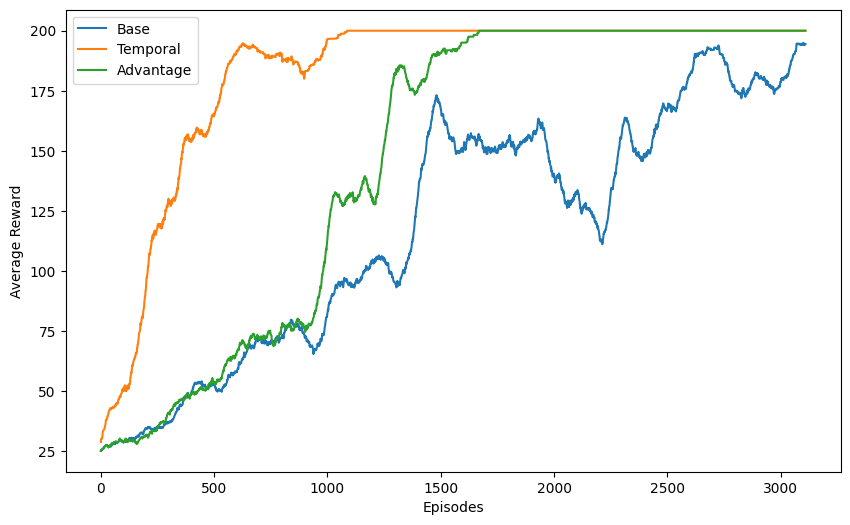

In [10]:
import matplotlib.pyplot as plt

rolling_average_window = 100
plt.figure(figsize=(10, 6))
avg_1 = [sum(rewards_1[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_1) - rolling_average_window)]
avg_2 = [sum(rewards_2[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_2) - rolling_average_window)]
avg_3 = [sum(rewards_3[i:i+rolling_average_window])/rolling_average_window for i in range(len(rewards_3) - rolling_average_window)]

plt.plot(avg_1, label='Base')
plt.plot(avg_2, label='Temporal')
plt.plot(avg_3, label='Advantage')

plt.xlabel('Episodes')
plt.ylabel('Average Reward')

plt.legend()
plt.show()

Clearly, the temporal structure and advantage normalization methods greatly improve over the baseline. The advantage normalization method seems to be a little slower, perhaps because it takes a little while for the value function network to become accurate enough to provide good normalization. 

### Effect of batch size

We will use the temporal structure method, because it converges quickly

In [6]:
batch_sizes = [1, 5, 10]

# Keep the other hyperparameters the same
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
gamma = 0.99

lr = 1e-3
n_episodes = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
all_experiment_rewards, all_experiment_losses = [], []
for bs in batch_sizes:
    policy_net = PG(input_dim, output_dim).to(device)
    optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
    
    policy_net, all_rewards, all_losses = train_pg(
                                            policy_net,
                                            optimizer,
                                            env,
                                            n_episodes,
                                            gamma,
                                            batch_size=bs,
                                            save_every=None,
                                            save_path=None,
                                            temporal=True,
                                            advantage=False,
                                            solved=(195, 100),
                                        )
    all_experiment_rewards.append(all_rewards)
    all_experiment_losses.append(all_losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]/DATA/charchit.sharma/py_irt_lib_test/test_rahul/playground/rl/pg.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages_tensor = torch.tensor(advantages, dtype=torch.float32, device=device)
Episode 1097/10000 | Reward: 196.25, Loss: 6266.490590820313:   0%|          | 0/10000 [03:06<?, ?it/s]           


Solved in 1097 episodes!


Episode 544/10000 | Reward: 195.09, Loss: 6017.745024414063:   0%|          | 0/10000 [09:03<?, ?it/s]             


Solved in 544 episodes!


Episode 726/10000 | Reward: 195.09899999999993, Loss: 6163.2750390625:   0%|          | 0/10000 [35:03<?, ?it/s]   

Solved in 726 episodes!


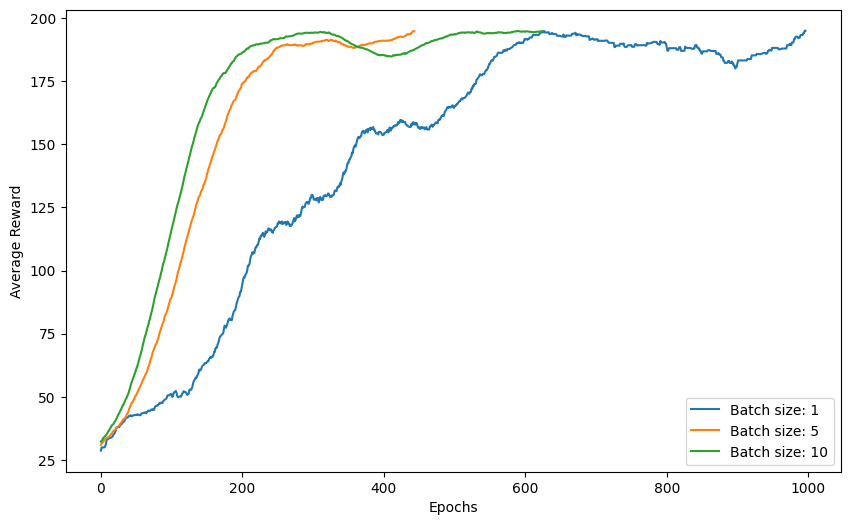

In [10]:
import matplotlib.pyplot as plt
rolling_average_window = 100

plt.figure(figsize=(10, 6))
for i, bs in enumerate(batch_sizes):
    avg = [sum(all_experiment_rewards[i][j:j+rolling_average_window])/rolling_average_window for j in range(len(all_experiment_rewards[i]) - rolling_average_window)]
    plt.plot(avg, label=f'Batch size: {bs}')
    
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.legend()

Clearly, a higher batch size seems to help with better policy gradient estimates, and therefore a convergence in less epochs.